## A short analysis of the stack overflow 2019 survey
Import some modules and read data from cvv-file.
Show some statistics about the salary of developers.
Remove salaries above 300k to get a more realistic view.

mean 127110.73842323056
min 0.0
max 2000000.0


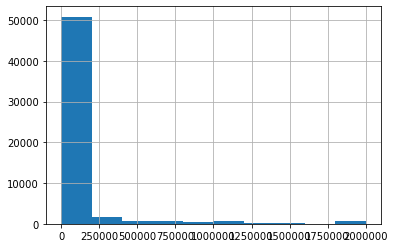

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns


df_start = pd.read_csv('./survey_results_public_19.csv')

print('mean', df_start['ConvertedComp'].mean())
print('min', df_start['ConvertedComp'].min())
print('max', df_start['ConvertedComp'].max())

df_start['ConvertedComp'].hist()
df_start = df_start[df_start['ConvertedComp'] < 300000]
plt.show()



Define some helper functions from the class room. 

In [3]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for i, col in  enumerate(cat_cols):
        print("Current col: ",i , col)
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df


def clean_and_factorize(df, response_col, cat_cols, dummy_na, category):
    '''
    SUMMARY: This function removes na values and factorizes the cat_cols so that categories become numeric values.
    
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    df_res - clean and factorized data frame
    
    '''
    #Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)
    df_nores = df.drop(columns=response_col)
    #Drop columns with all NaN values

    #Dummy categorical variables
    
    df_res = df_nores.apply(lambda x: pd.factorize(x)[0])
    #Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df_res = df_res.apply(fill_mean, axis=0)
    df_res[response_col] = df[response_col]

    print('new shape of data set: ', df_res.shape)

    #df_res.to_pickle("./temp_"+str(category)+".pkl")

    return df_res

def clean_and_dummy(df, response_col, cat_cols, dummy_na, category):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    

    '''

#Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(thresh = 0.75*df.shape[0], axis=1)

    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)
    df = df.dropna(how='any', axis=1)
    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    print('new shape of data set', df.shape)

    #df.to_pickle("./temp_"+str(category)+".pkl")

    return df

Define a function to train a random forest regression model and 
evaluate the importance of the features with respect to the response column. Plot the results.

In [14]:
def fit_data_reg(df, response_col):
    """Plot the imporportance of all features 
       based on a random forest regression algorithm
    
    Arguments:
        df {pandas data frame} -- data set}
        response_col {string} -- target value for prediction
    
    Returns:
        float, object -- train_score, test_score, lm_model
    """


    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    
    y = df[response_col]
    df = df.drop(response_col, axis=1)
    feature_names = df.columns
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=87)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    print('training data: ', X_train.shape)
    print('test data: ', X_test.shape)
    lm_model = RandomForestRegressor(random_state=0,
                            n_estimators=200, n_jobs = -1, verbose =2)#KNeighborsRegressor(n_neighbors=3)#LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    #Use the function

    rf = lm_model
    importances = rf.feature_importances_
    importances = importances * 100
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        print(feature_names[indices[f]])
    ind_lim = min(20, len(indices))
    # Plot the feature importances of the forest
    plt.subplots(figsize=(20,15))
    plt.style.use('ggplot')
    plt.title("Feature importances " + " (R²-score: "+str(round(train_score, 3))+")")
    plt.bar(range(ind_lim), importances[indices[0:ind_lim]],
       yerr=std[indices[0:ind_lim]], align="center",  color = 'tomato', alpha = 0.85)
    plt.xticks(range(ind_lim), feature_names[indices[0:ind_lim]], rotation='vertical')
    plt.ylabel('Feature importance [%]')
    plt.xlim([-1, ind_lim])
    plt.show()

    #color = 'dodgerblue', color = 'mediumspringgreen' , 'tomato', 'darkviolet'

Define the category of developer characteristics you want to take a look at. Define the response column.

In [10]:
category = 'tech'
response_col = 'ConvertedComp'
df_res = df_start[response_col]

basic_demo = ['MainBranch', 'Hobbyist', 'OpenSourcer', 'Employment' ,'Age', 'Country', 'Gender', 'Ethnicity', 'Dependents', 'Sexuality']


education = ['Student', 'EdLevel', 'UndergradMajor', 'EduOther', 'OrgSize', 'DevType',
                'YearsCode', 'Age1stCode', 'YearsCodePro', 'CareerSat', 'JobSat', 'MgrMoney' , 'MgrIdiot', 'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz',
                'JobFactors', 'ResumeUpdate', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge', 'WorkRemote', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 'UnitTests', 'PurchaseWhat', 'PurchaseHow']

tech = ['LanguageWorkedWith', 'DatabaseWorkedWith', 'PlatformWorkedWith', 'WebFrameWorkedWith', 'MiscTechWorkedWith', 'DevEnviron', 'OpSys', 'Containers', 'BlockchainOrg', 'BetterLife',
        'ITperson', 'SocialMedia', 'Extraversion']

community = ['SOVisit1st', 'SOVisitFreq', 'SOPartFreq', 'SOComm', 'SOJobs', 'SOAccount', ]



if category == 'basic_demo':
    df_start = df_start[basic_demo]
elif category == 'education':
    df_start = df_start[education]
elif category == 'tech':
    df_start = df_start[tech]
elif category == 'community':
    df_start = df_start[community]
else:
    df_start= df_start[basic_demo+education+tech+community]
df_start[response_col] = df_res

Get the categorical columns and factorize them. Plot the correlation between the features. 
Create feature importance plots based on the fit_data_reg() - function.

start cleaning and preparing data
new shape of data set:  (52045, 14)
training data:  (49442, 13)
test data:  (2603, 13)
building tree 1 of 200
building tree 2 of 200building tree 3 of 200
building tree 4 of 200



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 200
building tree 6 of 200
building tree 7 of 200building tree 8 of 200

building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s


building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.8s


building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished


Feature ranking:
1. feature 0 (14.707656)
LanguageWorkedWith
2. feature 5 (13.113814)
DevEnviron
3. feature 2 (12.367303)
PlatformWorkedWith
4. feature 1 (12.227984)
DatabaseWorkedWith
5. feature 3 (9.718287)
WebFrameWorkedWith
6. feature 4 (8.670129)
MiscTechWorkedWith
7. feature 11 (6.240391)
SocialMedia
8. feature 7 (6.231734)
Containers
9. feature 6 (4.321800)
OpSys
10. feature 10 (3.868556)
ITperson
11. feature 8 (3.630606)
BlockchainOrg
12. feature 12 (2.801734)
Extraversion
13. feature 9 (2.100005)
BetterLife


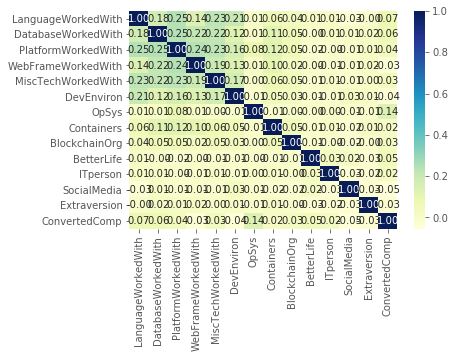

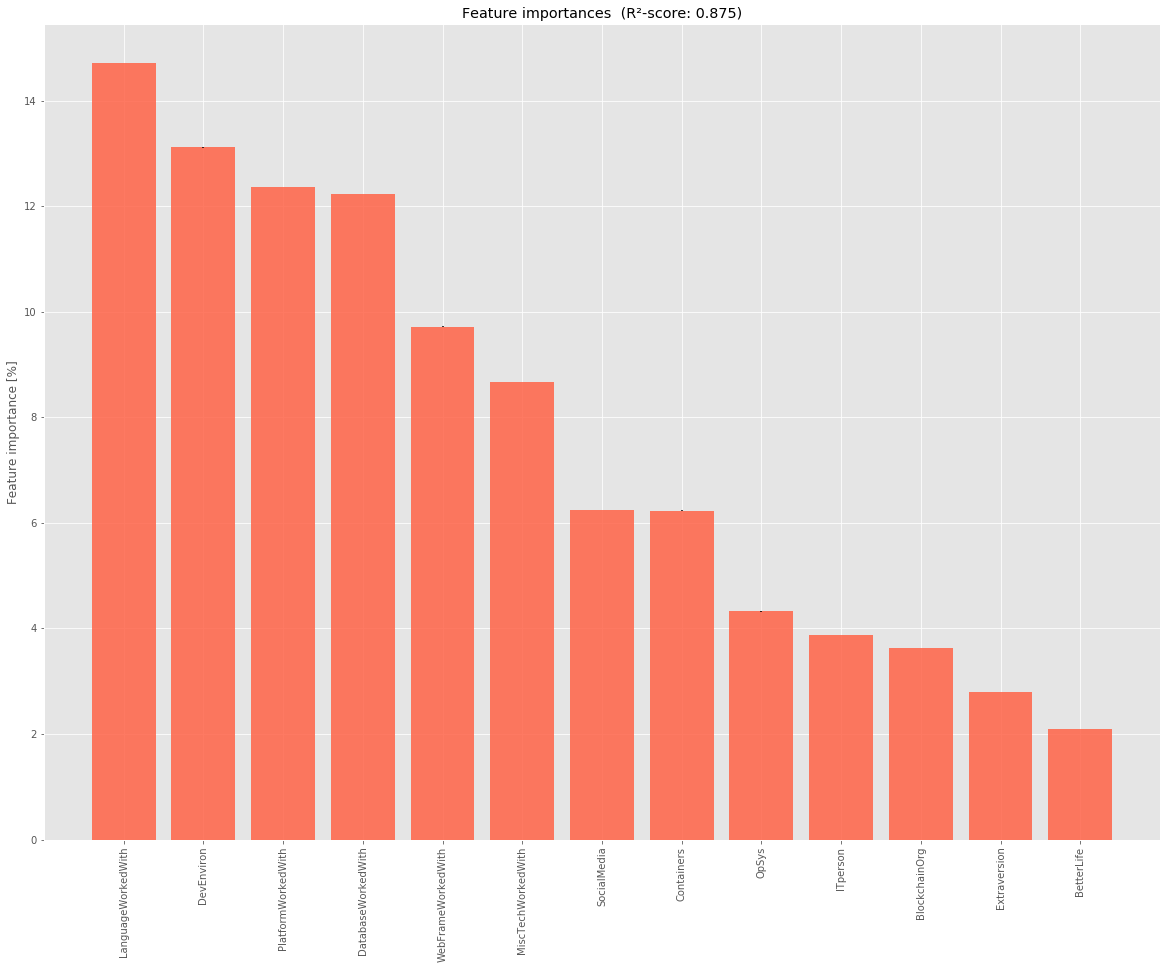

TypeError: 'NoneType' object is not iterable

In [15]:
#Create RF plots
#Pull a list of the column names of the categorical variables
cat_df = df_start.select_dtypes(exclude=['int', 'float'])
cat_cols_lst = cat_df.columns

print("start cleaning and preparing data")
## encode categorical values as numbers but do not add additional cols
df = clean_and_factorize(df_start, response_col, cat_cols_lst, dummy_na=False, category=category)
## plot stuff


## plot correlation heatmap
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="YlGnBu")

# fit data and create random forest plot
#plt.subplots(figsize=(20,15))
train_score,test_score,lm_model = fit_data_reg(df, response_col)

This function determines the impact of a category on salary (low/high paid group) and plots the results

In [19]:
def get_quantile_plot(df_new, category, response_col, low_q=0.25, high_q=0.75):
    """Determines the impact of a category on salary (low/high paid group)
        and plots the results
    
    Arguments:
        df_new {pandas data frame} -- input data
        category {string} -- name of category to be analyzed
        response_col {string} -- name of the response variable
    
    Keyword Arguments:
        low_q {float} -- low paid group quantile (default: {0.25})
        high_q {float} -- high paid group quantile (default: {0.75})
    """
    #get the higher quantiles
    df_new = df_new[df_new['ConvertedComp'] > df_new['ConvertedComp'].quantile(high_q)]
    ## split category names into different strings
    df_split = df_new[category].str.split(';', expand=True).add_prefix('name_')
    ## fill na values
    df_split.fillna(value=pd.np.nan, inplace=True)
    ## bring all columns together
    df_new['new_quantile_90'] = pd.concat(map(df_split.get, df_split.columns)).reset_index(drop=True)
   # print(df_new.head)
    ## count the responses for each type of category
    df_val_counts_q75 = df_new['new_quantile_90'].value_counts(normalize=False, dropna=True, sort=False)

    #get the lower  quantiles
    df_new = df_start[[category,response_col]]
    df_new = df_new[df_new['ConvertedComp'] < df_new['ConvertedComp'].quantile(low_q)]
    ## split category names into different strings
    df_split = df_new[category].str.split(';', expand=True).add_prefix('name_')
    #print(df_split.head)
    ## fill na values
    df_split.fillna(value=pd.np.nan, inplace=True)
    ## bring all columns together
    df_new['new_quantile_25'] = pd.concat(map(df_split.get, df_split.columns)).reset_index(drop=True)
    #print(df_new.head)
    ## count the responses for each type of category
    df_val_counts_q25 = df_new['new_quantile_25'].value_counts(normalize=False, dropna=True, sort= False)

    df_val_counts_q25 = df_val_counts_q25.sort_index()
    df_val_counts_q75 = df_val_counts_q75.sort_index()
    print('all devs: ', (df_val_counts_q25 + df_val_counts_q75))
    print('below 25 devs: ', df_val_counts_q25)
    print('abov 75 devs: ', df_val_counts_q75)
    df_norm_lower = df_val_counts_q25 #/ (df_val_counts_q25 + df_val_counts_q75)
    df_norm_higher = df_val_counts_q75 #/ (df_val_counts_q25 + df_val_counts_q75)
    ## merge bothe data frames
    df_merged = pd.merge(df_norm_lower, df_norm_higher, left_index=True, right_index=True)
    df_merged.index = df_merged.index.to_series().astype(str)
    ## perform zero padding in case of numerical string
    df_merged.index = df_merged.index.to_series().apply(lambda x: x.zfill(2))
    df_merged.sort_index(inplace=True)
    #normalized response values to the sum of all responses
    df_merged['new_quantile_low_norm'] = df_merged['new_quantile_25'] / np.sum(df_merged['new_quantile_25'])
    df_merged['new_quantile_high_norm'] = df_merged['new_quantile_90'] / np.sum(df_merged['new_quantile_90'])
    # create data frame for plot
    df_norm = pd.DataFrame({'Salary among the lowest ' + str(low_q) +' % (< ' + str(int(df_new['ConvertedComp'].quantile(low_q))) + " $/year)": df_merged['new_quantile_low_norm'].values,
                    'Salary among the highest ' + str(high_q) +' % (> ' + str(int(df_new['ConvertedComp'].quantile(high_q))) + " $/year)": df_merged['new_quantile_high_norm'].values}, index=df_merged.index)
    df_norm.plot(kind='bar', subplots=False)
    plt.ylabel('Survey participants - normalized [%]')
    plt.xlabel('Development environment')
    print('Sum of high paid group: ', np.sum(df_merged['new_quantile_90']))
    print('Sum of low paid group: ', np.sum(df_merged['new_quantile_25']))
    plt.show()

Analyze one specific feature by plotting the highest paid developers vs. 
lowest paid devs by the help of the get_quantile_plot() - function defined above.

<bound method NDFrame.head of                                               DevEnviron  ConvertedComp
2                                 Vim;Visual Studio Code         8820.0
3           Eclipse;Vim;Visual Studio;Visual Studio Code        61000.0
8                                                    Vim        95179.0
9      Android Studio;Eclipse;IPython / Jupyter;Notep...        13293.0
12            Vim;Visual Studio;Visual Studio Code;Xcode        90000.0
...                                                  ...            ...
88323  IntelliJ;Notepad++;PyCharm;Sublime Text;Vim;Vi...       180000.0
88325           IntelliJ;Sublime Text;Visual Studio Code       130000.0
88326         Android Studio;Notepad++;Vim;Visual Studio        82488.0
88328                       Emacs;Vim;Visual Studio Code        68745.0
88330                              IntelliJ;Sublime Text        22915.0

[52045 rows x 2 columns]>
Selected categorical columns Index(['DevEnviron'], dtype='object')
all devs: 

C:\Users\ChristianKnaak\.conda\envs\pyside2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 Android Studio        217.0
Atom                  166.0
Coda                   11.0
Eclipse               178.0
Emacs                  74.0
IPython / Jupyter     138.0
IntelliJ              356.0
Komodo                  NaN
Light Table             2.0
NetBeans               87.0
Notepad++             370.0
PHPStorm               99.0
PyCharm               170.0
RStudio                36.0
RubyMine               27.0
Sublime Text          338.0
TextMate               19.0
Vim                   321.0
Visual Studio         347.0
Visual Studio Code    755.0
Xcode                 142.0
Zend                    NaN
dtype: float64
below 25 devs:  Android Studio        158
Atom                   91
Coda                    2
Eclipse               132
Emacs                  15
IPython / Jupyter      61
IntelliJ              170
Komodo                  7
Light Table             1
NetBeans               79
Notepad++             227
PHPStorm               73
PyCharm                92
RStudio       

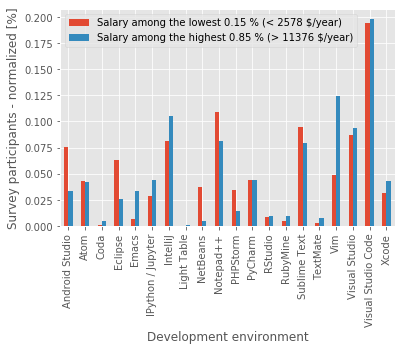

mean 63056.05866077433
min 0.0
max 299137.0


In [21]:
# Analyze one specific feature regarding the influence on salary
feature = 'DevEnviron'
## get  dummy columns for each category value
df_new = df_start[[feature,response_col]]
print(df_new.head)
# #Pull a list of the column names of the categorical variables
cat_df = df_new.select_dtypes(exclude=['int', 'float'])
cat_cols_lst = cat_df.columns
print('Selected categorical columns', cat_cols_lst)
#df = clean_and_dummy(df_new, response_col, cat_cols_lst, dummy_na=False, category=feature)
### analyze quantiles and plot results
#rint(df_new.head(5))
get_quantile_plot(df_new, feature, response_col, low_q=0.15, high_q=0.85)
print('mean', df_new['ConvertedComp'].mean())
print('min', df_new['ConvertedComp'].min())
print('max', df_new['ConvertedComp'].max())
#df_new['ConvertedComp'].hist()
plt.show()